In [40]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Gestione Database**

In [44]:
import firebase_admin
from firebase_admin import credentials, firestore
import requests
import pandas as pd
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt

#confinfurazione database
cred = credentials.Certificate('/content/key2.json') 
#firebase_admin.initialize_app(cred)

#inizializza istanza di firestore
db = firestore.client()

#Recupera i dati dalla collezione "Data"
data_ref = db.collection("Data")
docs = data_ref.get()

**Estrazione dati dal database**

In [45]:
#Crea un dataframe vuoto per i dati
df = pd.DataFrame()

#Estrarre i dati specifici dai documenti
weekend_count = 0
weekday_count = 0

for doc in docs:
    timestamp = doc.get("TimeStamp")
    date = datetime.strptime(timestamp, "%d/%m/%Y  %H:%M:%S")
    if date.weekday() >= 5:
        weekend_count += 1
    else:
        weekday_count += 1
    df = pd.concat([df, pd.DataFrame({'ds':[date], 'y':[weekend_count], 'y2':[weekday_count]})], ignore_index=True)

df['ds'] = pd.to_datetime(df['ds'])
df['day_of_week'] = df['ds'].dt.weekday

**Pre processing**

In [47]:
#piccolo pre proccessing:

#filtro i dati per un intervallo di date specifico (gennaio)
df = df[df['ds'].dt.month == 1]

#rimuovo le righe con valori mancanti
df = df.dropna()
missing_values = df.isna().sum()
print(missing_values)

ds             0
y              0
y2             0
day_of_week    0
dtype: int64


**Machine Learning con Prophet**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7zvny1dm/n65xgrvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7zvny1dm/70j4fl9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1021', 'data', 'file=/tmp/tmp7zvny1dm/n65xgrvi.json', 'init=/tmp/tmp7zvny1dm/70j4fl9b.json', 'output', 'file=/tmp/tmp7zvny1dm/prophet_model8geo57m2/prophet_model-20230120162756.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:27:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:

day_of_week
0    18
1     2
2     4
3     5
4    43
5    44
6    47
Name: y, dtype: int64


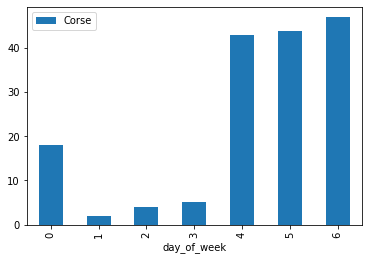

In [48]:
#Addestro il modello e effettua le previsioni
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

#Analizzo i dati per capire se ci sono più richieste nel weekend
print(df.groupby(by='day_of_week').sum().y)

df_january = df[df['ds'].dt.month == 1]
df_january.groupby(by='day_of_week').sum().plot(kind='bar', y='y', label='Corse')
plt.legend()
plt.show()

#Visualizzo le previsioni generate dal modello Prophet
m.plot(forecast)